In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import torch
DEVICE = torch.device('cpu')

NAME = 'ladle_furnace_inference'

# **Ladle furnace benchmark: inference**

In this example, we'll be analysing different **fill-level inference methods** for the task described in our initial [TomOpt paper](https://arxiv.org/abs/2309.14027). We aim at demonstrating the **capability** of the designed methods **to infer the fill level of a furnace ladle containing melted steel**. 


## **Building scenarios with different detector configurations**

We'll begin by defining the **number of simulations** we want to produce, their individual **data taking time**, and the considered **flux of muons**.

In [2]:
Simulations = 100 # number of simulations
Time = 5 # muography measurement time of a single simulation [min]
Flux = 6845 # considered flux of muons [muons/(min*m^2)]

Then, we will continue defining 4 scenarios with different detector configurations. Each scenario corresponds to a **volume**, consisting of the configured **detectors** and a **passive volume**. 

In [3]:
from tomopt.volume import Volume
from tomopt.benchmarks.ladle_furnace import get_detector

In [4]:
# Detection panel span [m]
PanelSpan = 0.7
# PanelSpan = 0.9

# muon hit detection resolution [m]
Resolution = 0.00001 # 0,01 mm (really high resolution)

PanelZ = [1.80, 1.65, 1.50, 0.30, 0.15, 0.00] # Big gap

volume_BigGapHighRes = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e5, panelZpositions=PanelZ), budget=6)
volume_BigGapHighRes

# muon hit detection resolution [m]
Resolution = 0.001 # 1 mm (common muography detector)

volume_BigGap = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_BigGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.25, 0.20] # Small gap

volume_SmallGap = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_SmallGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.15, 0.00] # Not centred

volume_NotCentred = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_NotCentred


Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5500]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
    (3): PassiveLayer located at z=tensor([1.2000])
    (4): PassiveLayer located at z=tensor([1.1000])
    (5): PassiveLayer located at z=tensor([1.])
    (6): PassiveLayer located at z=tensor([0.9000])
    (7): PassiveLay

We can visualise the layout of this in 3D.

<IPython.core.display.Javascript object>


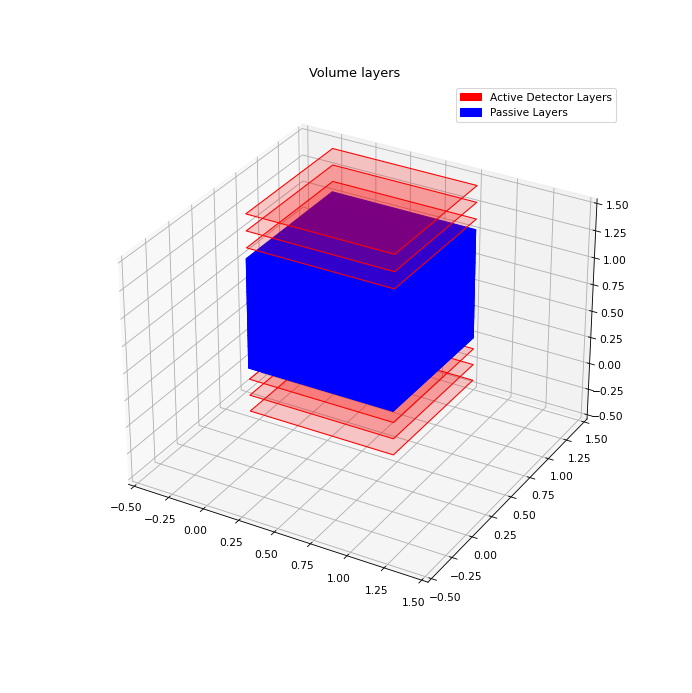

In [5]:
%matplotlib notebook
volume_BigGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

<IPython.core.display.Javascript object>


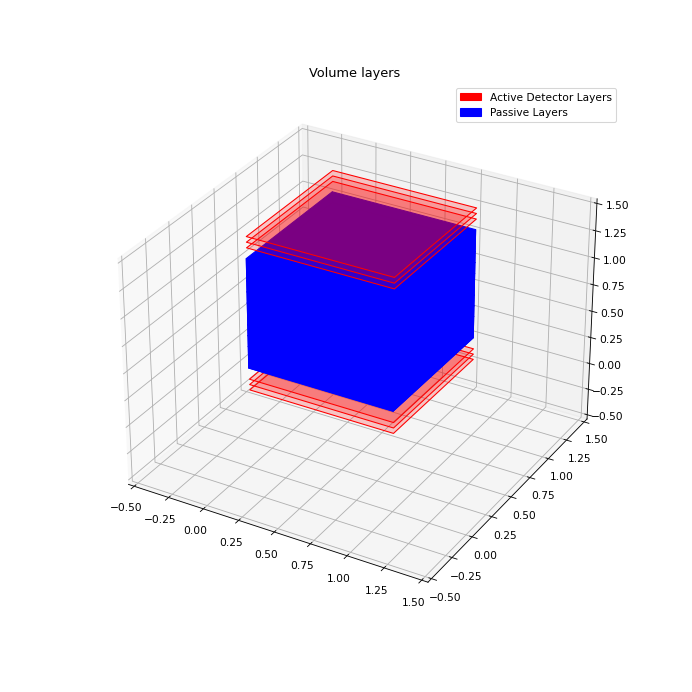

In [6]:
%matplotlib notebook
volume_SmallGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

<IPython.core.display.Javascript object>


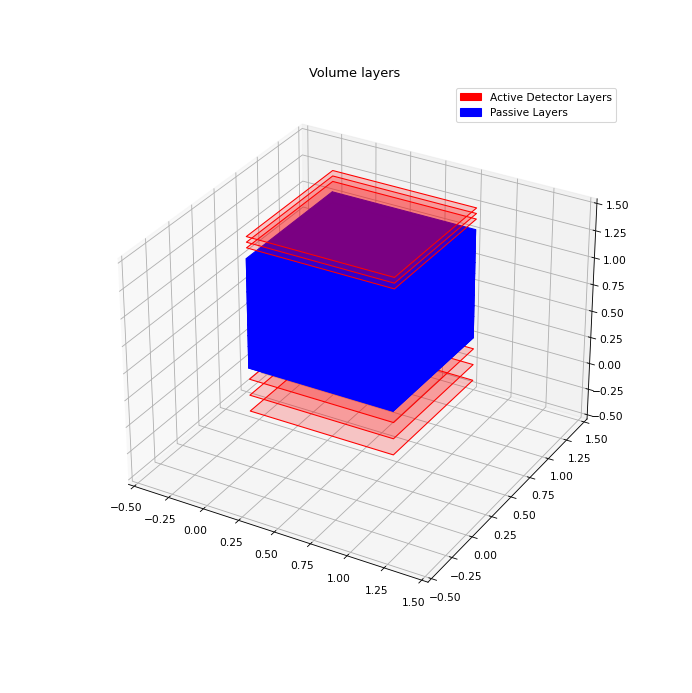

In [7]:
%matplotlib notebook
volume_NotCentred.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

In [20]:
%matplotlib inline

## **Passive volume generation**

Now we'll need to define how to **generate** example **passive volumes**. The furnace ladle is nade of several elements:

 - **Ladle**: a $1\times1\times1 \:[\text{m}^3]$ bucket made of solid steel.

 - **Liquid steel**: The ladle is filled with a **random amount** of liquid steel.

 - **Slag**: Above the liquid steel is a **layer** of **slag**, with a lower density that liquid steel.

 - **Air**: The rest of the ladle is filled with air.


`LadleFurnacePassiveGenerator` class will create layouts based on varying fill-heights of a furnace ladle, with varying levels of slag.

In [10]:
from tomopt.benchmarks.ladle_furnace import LadleFurnacePassiveGenerator

In [56]:
# Choose volume
volume=volume_BigGapHighRes
# volume=volume_BigGap
# volume=volume_SmallGap
# volume=volume_NotCentred

volume
# volume.get_detectors(), volume.get_passives()

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.8000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6500]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
    (3): PassiveLayer located at z=tensor([1.2000])
    (4): PassiveLayer located at z=tensor([1.1000])
    (5): PassiveLayer located at z=tensor([1.])
    (6): PassiveLayer located at z=tensor([0.9000])
    (7): PassiveLay

In [66]:
# Get X0 of all voxels
x0 = volume.get_rad_cube()
x0.shape, x0

(torch.Size([10, 10, 10]),
 tensor([[[1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-0

In [57]:
passive_gen = LadleFurnacePassiveGenerator(volume)

For a single training epoch, we'll generate 5 volumes at a range of fill-heights. The 10cm of slag will be present for ever volume.

In [58]:
N_PASSIVES_PER_H = 5
HEIGHTS = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

In [59]:
from tomopt.optimisation import PassiveYielder

In [60]:
trn_passives = PassiveYielder([passive_gen._generate(fixed_mat_z=h, fixed_slag_z=h+0.1)
                               for _ in range(N_PASSIVES_PER_H) for h in HEIGHTS])

In [61]:
len(trn_passives)

40

Let's visualise one these volume layouts by repurposing one of the visualisers in TomOpt

In [62]:
f,t = trn_passives.passives[0]
volume.load_rad_length(f, t)

In [63]:
from tomopt.plotting import plot_pred_true_x0
from tomopt.utils import x0targs_to_classtargs
from tomopt.core import X0

In [64]:
import numpy as np

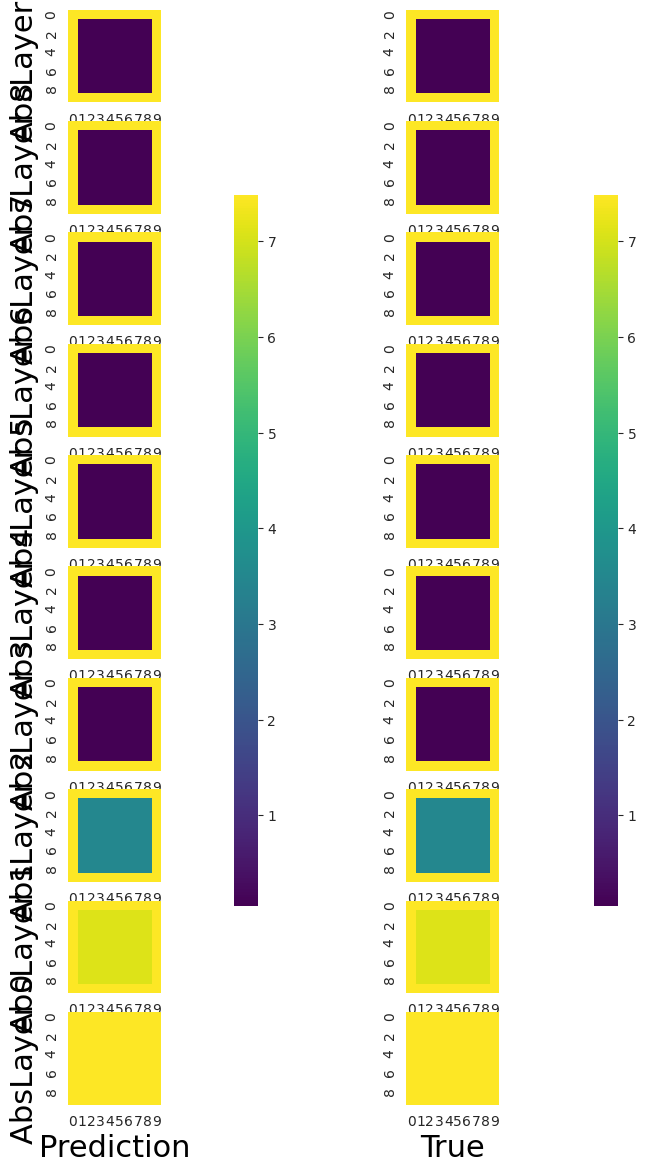

In [65]:
plot_pred_true_x0(1/np.sqrt(volume.get_rad_cube()), 1/np.sqrt(volume.get_rad_cube()))

Ignoring the predicted and true labels, on the right is the layers of the ladle, coloured by voxel material: 

 - Yellow = **ladle** (steel) 
 - Light green = **liquid steel** 
 - Dark green = **Slag** 
 - Blue = **Air**

On the left is the same set of layers, but coloured by material log_10 of the X0. We can see that the metals have very similar X0, but they are slightly distinguishable from the slag.

## **Develop inference method**


In [67]:
from tomopt.muon import MuonGenerator2016 as MuonGenerator

In [68]:
# gen = MuonGenerator.from_volume(volume, fixed_mom=5)
gen = MuonGenerator.from_volume(volume, fixed_mom=None)
gen

Muon generator: x,y range: (-0.40192377427276926, 1.4019237742727693), (-0.40192377427276926, 1.4019237742727693). Energy sampled from 0.5087855416698359-491.5127197474533 GeV.

In [70]:
from tomopt.muon import MuonBatch

In [71]:
muons = MuonBatch(gen(1000), init_z=1.8)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.5698), muons.y[0]=tensor(0.7240), muons.z[0]=tensor(1.8000), muons.theta[0]=tensor(0.3635)'

In [72]:
volume(mu=muons)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(1.1992), muons.y[0]=tensor(1.0050), muons.z[0]=tensor(0.), muons.theta[0]=tensor(0.3712)'

In [73]:
hits = muons.get_hits()
hits

{'above': {'reco_xyz': tensor([[[ 0.5697,  0.7240,  1.8000],
           [ 0.6219,  0.7471,  1.6500],
           [ 0.6741,  0.7702,  1.5000]],
  
          [[ 1.1820,  1.3497,  1.8000],
           [ 1.2681,  1.2665,  1.6500],
           [ 1.3568,  1.1807,  1.5000]],
  
          [[ 0.1728,  0.8591,  1.8000],
           [ 0.3185,  0.7307,  1.6500],
           [ 0.4642,  0.6022,  1.5000]],
  
          ...,
  
          [[ 1.3818,  0.7482,  1.8000],
           [ 1.3943,  0.7452,  1.6500],
           [ 1.4265,  0.7421,  1.5000]],
  
          [[ 1.2730,  0.2394,  1.8000],
           [ 1.3140,  0.1924,  1.6500],
           [ 1.3582,  0.1454,  1.5000]],
  
          [[ 0.6926, -0.2814,  1.8000],
           [ 0.7290, -0.2512,  1.6500],
           [ 0.7655, -0.2227,  1.5000]]], grad_fn=<StackBackward0>),
  'gen_xyz': tensor([[[ 0.5698,  0.7240,  1.8000],
           [ 0.6219,  0.7471,  1.6500],
           [ 0.6741,  0.7702,  1.5000]],
  
          [[ 1.1820,  1.3497,  1.8000],
           [ 1.26

In [74]:
hits['above']['reco_xyz'].shape  # (muons, detector layer, xy)

torch.Size([1000, 3, 3])

In [76]:
%%time
sb = ScatterBatch(mu=muons, volume=volume)

CPU times: user 22.9 ms, sys: 0 ns, total: 22.9 ms
Wall time: 13.7 ms


In [77]:
%%time
sb.poca_xyz, sb.poca_xyz_unc

CPU times: user 5.86 s, sys: 2.14 s, total: 8 s
Wall time: 5.05 s


(tensor([[1.0210, 0.9239, 0.5027],
         [0.9797, 0.1493, 0.9703],
         [0.1530, 0.9644, 1.3488],
         ...,
         [0.5281, 0.4505, 0.4434],
         [0.9807, 0.4101, 1.2798],
         [1.5208, 0.7292, 0.8684]], grad_fn=<AddBackward0>),
 tensor([[2.4482e-03, 1.1155e-03, 6.9382e-03],
         [3.0341e-03, 2.6830e-03, 3.1210e-03],
         [5.2042e-04, 2.3155e-04, 4.5125e-04],
         ...,
         [1.0582e-04, 2.3955e-04, 6.5544e-04],
         [2.9054e-04, 2.5024e-04, 8.2411e-04],
         [6.2303e-02, 8.4868e-03, 4.1715e-01]], grad_fn=<SqrtBackward0>))

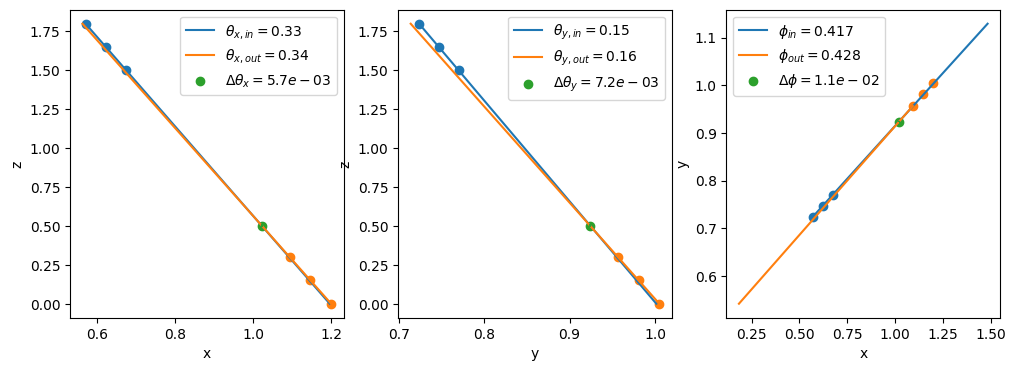

In [78]:
sb.plot_scatter(idx=0)

## **D - Inference**

In [83]:
import matplotlib.pyplot as plt

In [84]:
1/np.sqrt(volume.get_rad_cube()[:,4,4])

tensor([7.4911, 7.0870, 3.4898, 0.0574, 0.0574, 0.0574, 0.0574, 0.0574, 0.0574,
        0.0574])

0.1

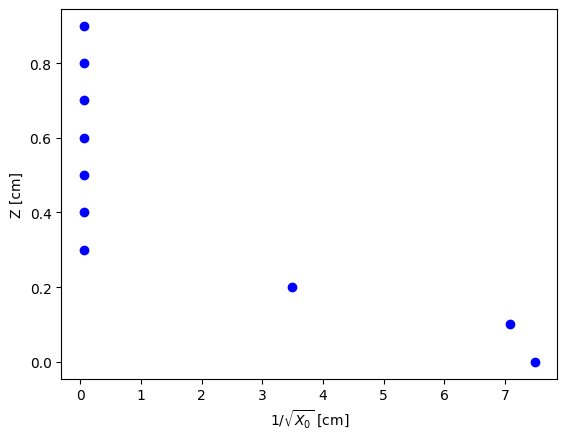

In [85]:
# Get true steel level
plt.plot(1/np.sqrt(volume.get_rad_cube()[:,4,4]), np.arange(0, len(np.sqrt(volume.get_rad_cube()[:,4,4])))*0.1, "bo")
plt.xlabel(r"$1/\sqrt{X_0}$ [cm]")
plt.ylabel("Z [cm]")

PassiveLayerThickness = 0.1
SteelLevel_True = np.unique(volume.get_rad_cube()[:,4,4]==volume.get_rad_cube()[1,4,4], return_counts=True)[1][1]*PassiveLayerThickness
SteelLevel_True

In [88]:
PocaZ = sb.poca_xyz[:, 2].detach().numpy()
FurnaceBottom = 0.5
SteelLevel_Pred = (np.mean(PocaZ)-FurnaceBottom)*2
print("Actual steel level: " + str(round(SteelLevel_True, 4)))
print("Predicted steel level: " + str(round(SteelLevel_Pred, 4)))
np.mean(PocaZ)

Actual steel level: 0.1
Predicted steel level: 0.3524


0.6761943

(array([  1.,   0.,   1.,   0.,   2.,   0.,   1.,   3.,  16.,  39., 151.,
        170.,  95., 103.,  66.,  11.,   4.,   4.,   2.,   1.]),
 array([-2.84999442, -2.55386209, -2.25772977, -1.96159732, -1.66546488,
        -1.36933255, -1.07320023, -0.77706778, -0.48093542, -0.18480305,
         0.11132932,  0.4074617 ,  0.70359409,  0.99972641,  1.29585886,
         1.59199119,  1.88812351,  2.18425584,  2.4803884 ,  2.77652073,
         3.07265306]),
 <BarContainer object of 20 artists>)

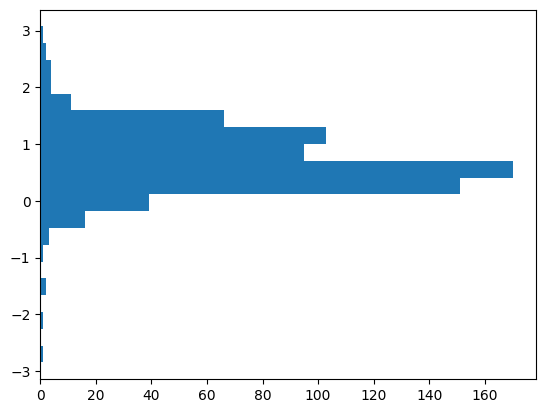

In [87]:
plt.hist(PocaZ, bins=20, orientation="horizontal")

In [221]:
# Run multiple simulations and get POCA

# Model steel level depending on Zpoca mean (1st, and 2nd order)

# Invert and get inference
